## Topic: Analysing A/B testing results and performing logistic regressions

This exercise is part of a project of the [Udacity Data Analyst Nanodegree course](https://www.udacity.com/course/data-analyst-nanodegree--nd002) that I am currently undertaking. 

## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
# Read in dataset
df = pd.read_csv('./data/ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Explore dataset
df.shape

(294478, 5)

In [4]:
# Missing values?
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [5]:
# Number of unique users
df['user_id'].nunique()

290584

In [6]:
# Remove duplicated user_id
df = df[~df['user_id'].duplicated()]

In [7]:
# The number of times the groups and landing pages don't match
((df['group'] == 'control') & (df['landing_page'] != 'old_page')).sum()

1006

In [8]:
((df['group'] != 'control') & (df['landing_page'] == 'old_page')).sum()

1038

In [9]:
1928 + 1965

3893

In [10]:
# Remove the mismatched groups and landed pages
df_control = df[((df['group'] == 'control') & 
                (df['landing_page'] == 'old_page'))]

df_treatment = df[((df['group'] == 'treatment') & 
                (df['landing_page'] == 'new_page'))]

df2 = df_control.append(df_treatment)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

What is the probability of an individual converting regardless of the page they receive?

In [12]:
df2['converted'].mean()

0.11950856033825466

Given that an individual was in the `control` group, what is the probability they converted?

In [13]:
df2.query('group == "control"')['converted'].mean()

0.12029037760181936

Given that an individual was in the `treatment` group, what is the probability they converted?

In [14]:
df2.query('group == "treatment"')['converted'].mean()

0.11872721981235362

What is the probability that an individual received the new page?

In [15]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5001524918555487

<b>Observations:</b>

1. From the probabilities above, there is still insufficient evidence to make any conclusions. 

2. These probabilities may not be representative of the true value. 

3. That said, we have quite a large sample size of 290,584 unique subjects.

<a id='ab_test'></a>
### Part II - A/B Test

For now, say I'd need to make a decision just based on all the data provided. If I wanted to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, my hypotheses would be constructed as such:

`Null hypothesis:` There is a lower number of conversions in the treatment/ new page group as compared to the control/ old page group ($p_{new}$ - $p_{old}$ <= 0)

`Alternative hypothesis:` There is a higher number of conversions in the treatment/ new page group as compared to the control/ old page group  ($p_{new}$ - $p_{old}$ > 0)

We're going to assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the conversion success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the conversion rate in **ab_data.csv** regardless of the page.

What is the conversion rate for $p_{new}$ under the null? It would be the same for $p_{old}$ under the null too.

In [16]:
df['converted'].mean() 

0.1195695564793657

I will now perform a sampling distribution for the difference in conversion between the two pages over 10,000 iterations of calculating an estimate from the null.

Out of curiosity, I wanted to employ different methods of performing the sampling distribution, to see for myself if the mean values of these samples remain the same/ similar to each other. In theory, they should.

In [18]:
from tqdm import tqdm

In [19]:
n_new = len(df.query('group == "treatment"')) # sample size of treatment group
n_old = len(df.query('group == "control"')) # sample size of control group
p_new = df['converted'].mean() # probability under null - based on assumption given
p_old = df['converted'].mean() # probability under null - based on assumption given


In [20]:
# Method 1 of getting the sampling distribution
control_sample_mean = np.random.binomial(n = n_old, p = p_new, size = 10000)/n_old
treatment_sample_mean = np.random.binomial(n = n_new, p = p_new, size = 10000)/n_new
p_diffs1 = treatment_sample_mean - control_sample_mean

In [21]:
# Method 2 of getting the sampling distribution using for loop
p_diffs2 = [] # values stored in this list are values given the null hypothesis is true ie pnew = pold

for i in tqdm(range(10000)):
    control_sample_mean = np.random.choice([0,1], size = len(df.query('group == "control"')),
                                           p = [1 - df['converted'].mean(), df['converted'].mean()]).mean()
    treatment_sample_mean = np.random.choice([0,1], size = len(df.query('group == "treatment"')),
                                             p = [1 - df['converted'].mean(), df['converted'].mean()]).mean()
    p_diffs2.append(treatment_sample_mean - control_sample_mean)

100%|██████████| 10000/10000 [07:15<00:00, 22.98it/s]


In [22]:
# Method 3 of getting the sampling distribution using bootstrapping
p_diffs_bootstrap = []

for _ in tqdm(range(10000)):
    control_sample = df2.sample(len(df.query('group == "control"')), replace = True)
    treatment_sample = df2.sample(len(df.query('group == "treatment"')), replace = True)
    control_sample_mean = control_sample.query('group == "control"')['converted'].mean()
    treatment_sample_mean = treatment_sample.query('group == "treatment"')['converted'].mean()
    p_diffs_bootstrap.append(treatment_sample_mean - control_sample_mean)
    
# simulate values above given the null hypothesis is true
null_values = np.random.normal(0, np.std(p_diffs_bootstrap), 10000)

100%|██████████| 10000/10000 [16:51<00:00,  9.89it/s]


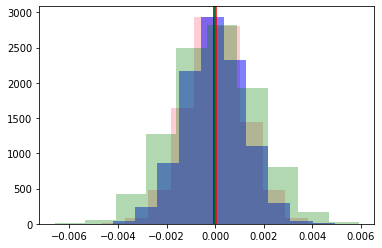

In [23]:
# Plot 3 histograms side by side to see how similar the above null values 
# are from the different methods
plt.hist(p_diffs1, alpha = 0.8, color = 'pink')
plt.axvline(np.mean(p_diffs1), color = 'red')
plt.hist(p_diffs2, alpha = 0.5, color = 'blue')
plt.axvline(np.mean(p_diffs2), color = 'blue')
plt.hist(null_values, alpha = 0.3, color = 'green')
plt.axvline(np.mean(null_values), color = 'green');

Plot another histogram using the null values from the first method, and comparing where the observed statistic of difference in conversion lies at.

In [24]:
observed_diff = df.query('group == "treatment"')['converted'].mean() - df.query('group == "control"')['converted'].mean()
observed_diff

-0.001454645698457463

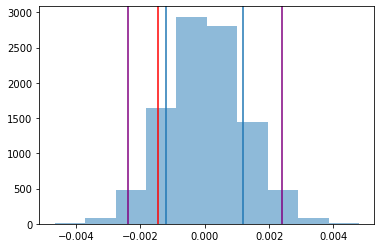

In [25]:
plt.hist(p_diffs1, alpha = 0.5)
plt.axvline(-np.std(p_diffs1)*1) # 1 SD
plt.axvline(np.std(p_diffs1)*1)
plt.axvline(-np.std(p_diffs1)*2, color = 'purple') # 2 SD
plt.axvline(np.std(p_diffs1)*2, color = 'purple')
plt.axvline(observed_diff, color = 'red'); # normally distributed histogram

<b>Observations: </b>

1. We see that if the null hypothesis is true, we'd expect $p_{new}$ - $p_{old}$ <= 0. 

2. Our observed statistic does show a difference of -0.0015 (-0.15%) between the treatment and control groups, indicating that there is already evidence to suggest that the null hypothesis is true ie we assume that the old page is better than the new.

3. The above histogram is centered around 0, with the observed statistic falling approximately 1 standard deviation away from the mean. 

Calculate the p-value

In [26]:
(p_diffs1 > observed_diff).mean()

0.8918

<b>Observations:</b>

1. Is our observed statistic of converted difference between both groups due to an actual difference, or is it simply due to chance? 

2. From our p-value, we see that given the null hypothesis is true, there is a probability of 89% that we will observe our statistic from the data (with a Type 1 error rate of 5%). 

3. Thus, we say that we have insufficient evidence to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

Since each row is either a conversion or no conversion, I will be performing a logistic regression (as opposed to a linear regression).

The goal is to use <i>statsmodels</i> to fit the regression model I specified before to see if there is a significant difference in conversion based on which page a customer receives. 

I'd first need to create an intercept column, and create a dummy variable for which page each user received.

In [27]:
df2['intercept'] = 1
df2 = df2.join(pd.get_dummies(df2['group']))
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


I will next instantiate my regression model on the new columns I just created, and subsequently fit the model to predict whether or not an individual converts based on the page (old or new/ control or treatment group).

In [33]:
from scipy import stats
import statsmodels.api as sm
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)

In [34]:
# Instantiate and fit regression model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'treatment']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.365942
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               288540
Model:                          Logit   Df Residuals:                   288538
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 May 2021   Pseudo R-squ.:               7.932e-06
Time:                        15:17:30   Log-Likelihood:            -1.0559e+05
converged:                       True   LL-Null:                   -1.0559e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1956
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9897      0.008   -245.805      0.000      -2.006      -1.974
treatment     -0.0149      0.011     -1.294      0.196      -0.037       0.008
==============================================================================
"""

In [35]:
# Exponentiate coefficients
results.params

intercept   -1.989683
treatment   -0.014855
dtype: float64

In [36]:
np.exp(results.params)

intercept    0.136739
treatment    0.985254
dtype: float64

<b>Observations</b>:

1. It seems like getting a convert is only 0.99 times as likely when a new page is given than an old page, holding all else constant. 

2. However, the p-value associated to this treatment coefficient indicates that it is not significantly significant. 

3. The p-value associated with my hypothesis testing was 0.19. The p-value from my regression model was 0.9.

4. The null and alternative hypotheses of the two are set up differently. In the regression model, the null hypothesis is that being in the treatment/ new page group does not affect the likelihood of one's conversion (one sided t-test).

5. The p-value of 0.19 in the regression model says that we have insufficient evidence to reject the null hypothesis. As such, as it stands, being given the new page does not affect one's likelihood of being converted.

Now, along with testing if the conversion rate changes for different pages, I will also add an effect based on which country a user lives in. 

I will read in a new dataset **countries.csv** and merge it with the current one.

Does it appear that country had an impact on conversion? 

In [37]:
countries_df = pd.read_csv('./data/countries.csv')
countries_df.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [40]:
countries_df['user_id'].nunique()

290584

In [41]:
df2['user_id'].nunique()

288540

In [45]:
countries_df = countries_df[countries_df['user_id'].isin(df2['user_id'].unique().tolist())]

In [46]:
# Check if no. of unique user_ids in countries_df is the same as in df2
assert countries_df['user_id'].nunique() == df2['user_id'].nunique()

In [47]:
# Merge datasets
new_df = pd.merge(left = countries_df, right = df2, on = 'user_id')
new_df.head(2)

,user_id,country,timestamp,group,landing_page,converted,intercept,control,treatment
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1


In [48]:
# Create new dummy variable for country
new_df = new_df.join(pd.get_dummies(new_df['country']))
new_df.head(2)

,user_id,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1


In [49]:
# Instantiate and fit regression model
log_mod2 = sm.Logit(new_df['converted'], new_df[['intercept', 'treatment', 'CA', 'US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.365936
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               288540
Model:                          Logit   Df Residuals:                   288536
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 May 2021   Pseudo R-squ.:               2.288e-05
Time:                        15:19:07   Log-Likelihood:            -1.0559e+05
converged:                       True   LL-Null:                   -1.0559e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1845
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9804      0.013   -154.888      0.000      -2.005      -1.955
treatment     -0.0148      0.011     -1.290      0.197      -0.037       0.008
CA            -0.0503      0.029     -1.765      0.078      -0.106       0.006
US            -0.0098      0.013     -0.733      0.464      -0.036       0.016
==============================================================================
"""

In [50]:
# Exponentiate
np.exp(results.params)

intercept    0.136739
treatment    0.985254
dtype: float64

**Observations:**

1) It doesn't look like the conversion rates are dependent on either one country. Their p-values do not reflect statistical significance. 

Next, I would now like to look at an interaction between page and country to see if there are significant effects on conversion.

In [51]:
# create new interaction columns
new_df['converted_CA'] = new_df['converted'] * new_df['CA']
new_df['converted_UK'] = new_df['converted'] * new_df['UK']
new_df['converted_US'] = new_df['converted'] * new_df['US']
new_df.head(2)

,user_id,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US,converted_CA,converted_UK,converted_US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0,0


In [52]:
# Instantiate and fit regression model
log_mod3 = sm.Logit(new_df['converted'], new_df[['intercept', 'converted_US', 'US', 'converted_CA', 'CA']])
results3 = log_mod3.fit()
results3.summary()

         Current function value: 0.091756
         Iterations: 35


/opt/anaconda3/envs/udacity_nanodegree/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               288540
Model:                          Logit   Df Residuals:                   288535
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 May 2021   Pseudo R-squ.:                  0.7493
Time:                        15:19:09   Log-Likelihood:                -26475.
converged:                      False   LL-Null:                   -1.0559e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9877      0.011   -173.586      0.000      -2.010      -1.965
converted_US    44.8371   2664.979      0.017      0.987   -5178.425    5268.099
US             -25.8777   2664.796     -0.010      0.992   -5248.783    5197.027
converted_CA    42.4612   1151.755      0.037      0.971   -2214.936    2299.859
CA             -19.0456    327.213     -0.058      0.954    -660.371     622.280
================================================================================

Possibly complete quasi-separation: A fraction 0.75 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**Observations:**

1) All p-values remain insignificant. Countries and treatments do not seem to affect the rate of conversion (overall and as interactions).

**Conclusions:**

1) The new page should not be implemented. 

2) A higher number of conversions were observed when the old page was used. 

3) Our hypothesis test tells us that there is insufficient evidence to reject the claim that the new page is producing more conversions than the old.